In [ ]:
!nvidia-smi

Wed Aug 19 11:07:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow-gpu

%tensorflow_version 2.x

     |████████████████████████████████| 320.4MB 54kB/s 


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive

drive.mount("./gdrive", force_remount=True)

%cd "./gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src/"
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/handwritten-text-recognition/src
total 35
drwx------ 2 root root  4096 Jun  8 16:35 data
-rw------- 1 root root  9387 Jun  2 10:58 main.py
drwx------ 2 root root  4096 Jun  8 16:35 network
-rw------- 1 root root 17716 Jun  2 10:58 tutorial.ipynb


In [ ]:
import os
import datetime
import string

# define parameters
source = "iam"
arch = "flor"
epochs = 200
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/iam.hdf5
output ../output/iam/flor
target ../output/iam/flor/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [ ]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 5369
Validation images: 744
Test images: 1425


In [ ]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=arch, input_size=input_size, vocab_size=dtgen.tokenizer.vocab_size)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 64, 16)       160       
_________________________________________________________________
p_re_lu (PReLU)              (None, 512, 64, 16)       16        
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 64, 16)       112       
_________________________________________________________________
full_gated_conv2d (FullGated (None, 512, 64, 16)       4640      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 64, 32)       4640      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 512, 64, 32)      

In [ ]:
%load_ext tensorboard
%tensorboard --reload_interval=300 --logdir={output_path}

In [ ]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])
with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/200
336/336 [==============================] - ETA: 0s - loss: 127.7498
Epoch 00001: val_loss improved from inf to 102.04208, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 66s 197ms/step - loss: 127.7498 - val_loss: 102.0421
Epoch 2/200
336/336 [==============================] - ETA: 0s - loss: 84.8943
Epoch 00002: val_loss improved from 102.04208 to 62.67791, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 64s 192ms/step - loss: 84.8943 - val_loss: 62.6779
Epoch 3/200
336/336 [==============================] - ETA: 0s - loss: 57.9465
Epoch 00003: val_loss improved from 62.67791 to 39.93803, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 64s 192ms/step - loss: 57.9465 - val_loss: 39.9380
Epoch 4/200
336/336 [==============================] - ETA: 0s - loss: 44.0677
Epoch 00004: val_loss improved from 39.93803 to 30.

Model Predict
90/90 [==============================] - 4s 46ms/step
CTC Decode
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
90/90 [==============================] - 89s 991ms/step



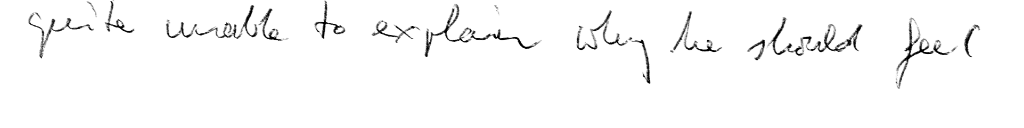

quite unable to explain why he should feel
qpeite unable to explain why he should feet 




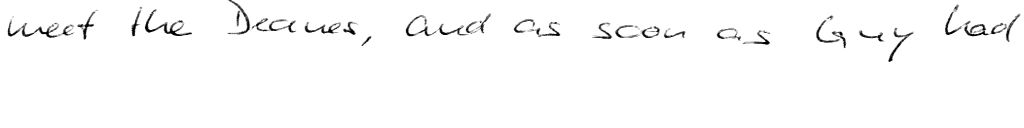

meet the Deanes , and as soon as Guy had
meet the Deanes , and as scon as Gny had 




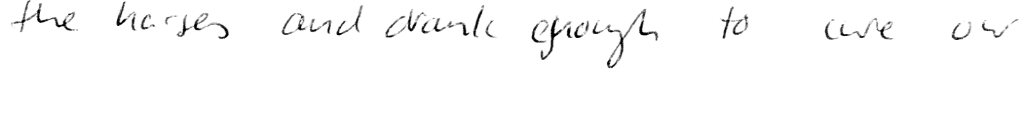

the horses and drank enough to cure our
the harses and dank grough to cure ou 




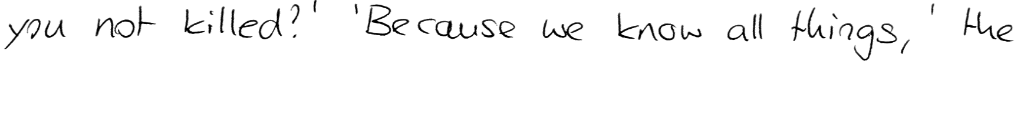

you not killed ? ' ' Because we know all things , ' the
you not killed ! ' ' Because we know all things , ' the 




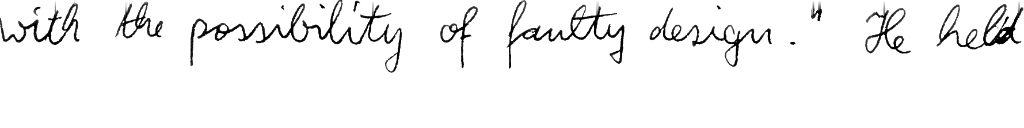

with the possibility of faulty design . " He held
with the possibility of faubty design . " He held 




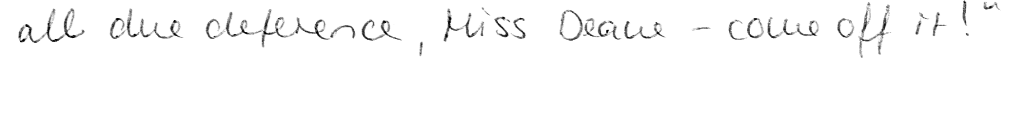

all due deference , Miss Deane - come off it !
all due deference , Miss deaue - come off it ! 




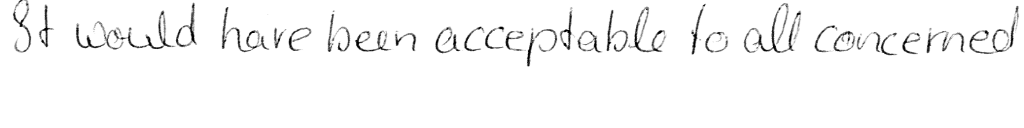

It would have been acceptable to all concerned
Bt would have been acceptable to all concerned 




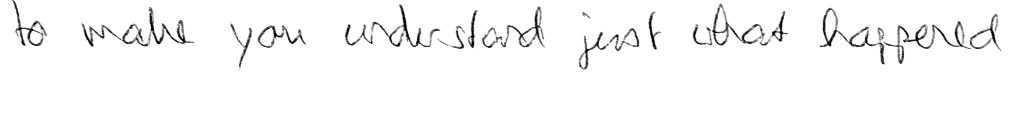

to make you understand just what happened
to make you understard just what happered 




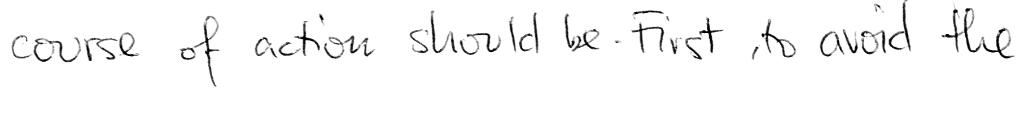

course of action should be . First , to avoid the
course of action should be . First , to avoid the 




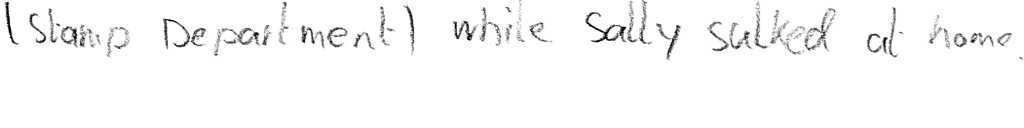

( Stamp Department ) while Sally sulked at home .
( stamp Department ) while sally sulked at home . 



In [ ]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, dtgen.dataset['test']['gt']):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 350, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(dtgen.dataset['test']['gt'][i])
    print(predicts[i], "\n")

In [ ]:
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts=predicts,
                                  ground_truth=dtgen.dataset['test']['gt'])

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    1425
Total time:           0:01:34.720739
Time per item:        0:00:00.066471

Metrics:
Character Error Rate: 0.05956974
Word Error Rate:      0.19398749
Sequence Error Rate:  0.78105263
